# Object classification using K-means clustering

In [2]:
from skimage import io, color, morphology, filters, data, exposure, segmentation, measure
from matplotlib import pyplot as plt
import numpy as np
from scipy.cluster.vq import kmeans, vq

In [3]:
def plot(img, is_color=False):
    plt.figure(figsize=(8,8))
    if is_color:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap = plt.cm.gray)
        
def plot_subplots(img1, img2):
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap = plt.cm.gray)
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap = plt.cm.gray)
    plt.show()

## Read image

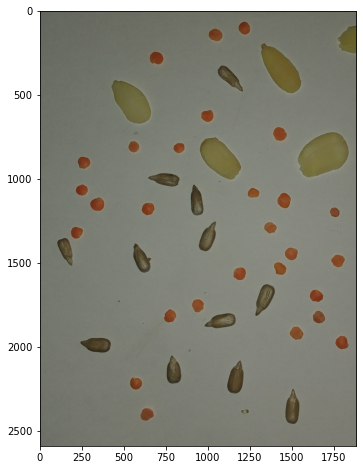

In [7]:
img = io.imread('seeds.png')
plot(img, True)

## Preprocessing

#### 1) RGB -> gray

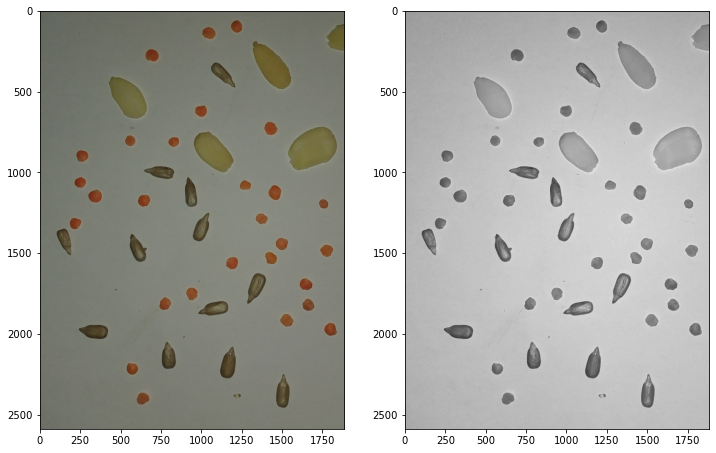

In [8]:
img_gray = color.rgb2gray(img)
plot_subplots(img, img_gray)

#### 2) negative

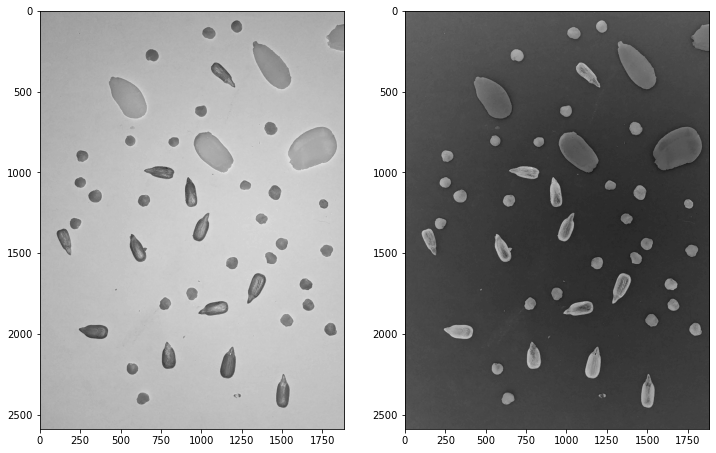

In [9]:
img_negative = 1-img_gray
plot_subplots(img_gray, img_negative)

#### 3) histogram equalization

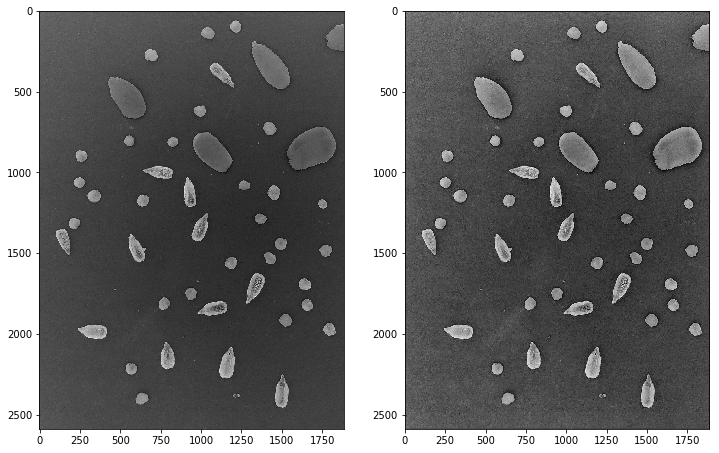

In [6]:
img_equalized = exposure.equalize_adapthist(img_negative)
img_equalized = (img_equalized*255).astype('uint8')
plot_subplots(img_negative, img_equalized)

#### 4) mean filtering

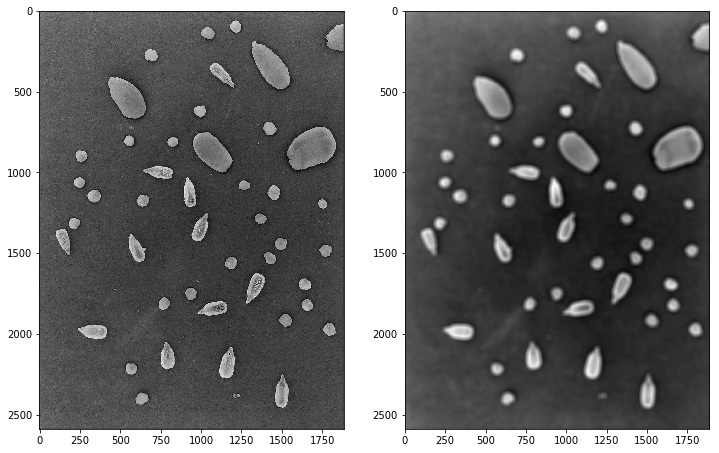

In [7]:
img_filtered = filters.rank.mean(img_equalized, np.ones([31,31]))
plot_subplots(img_equalized, img_filtered)

#### 5) thresholding and binarization

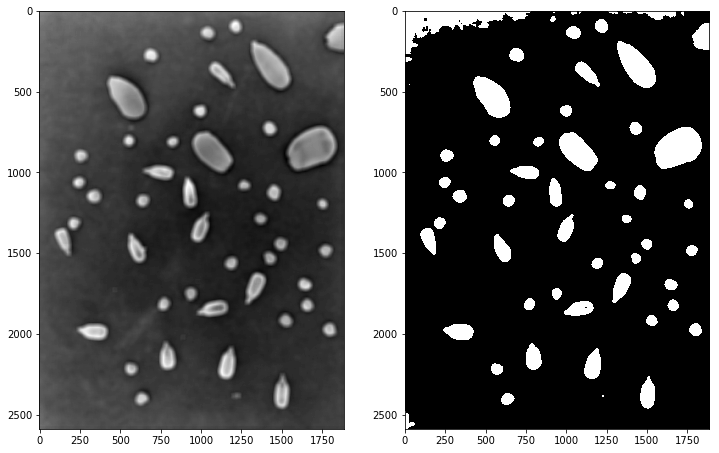

In [8]:
threshold = filters.threshold_otsu(img_filtered)
img_bin = img_filtered > threshold
plot_subplots(img_filtered, img_bin)

#### 6) clear borders

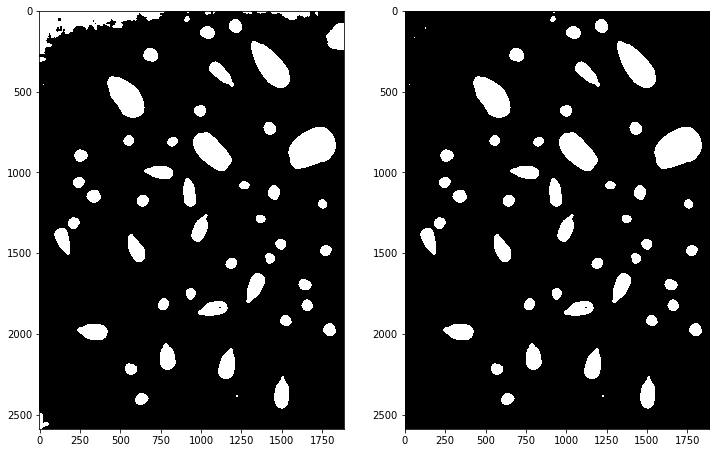

In [9]:
img_cleared_borders = segmentation.clear_border(img_bin)
plot_subplots(img_bin, img_cleared_borders)

#### 7) remove noise - binary opening

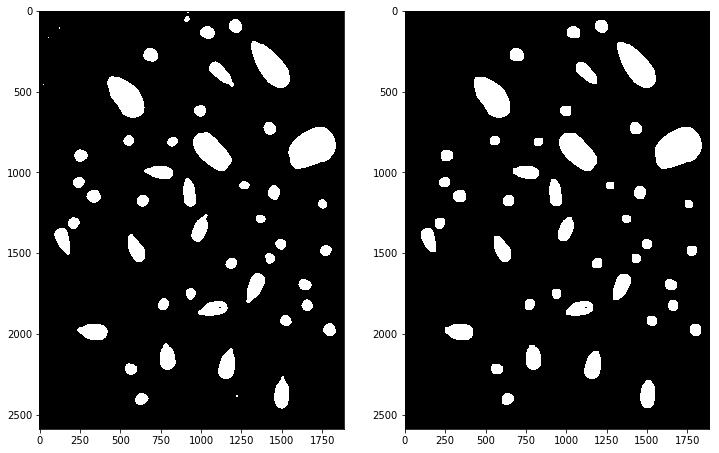

In [10]:
img_opened = morphology.binary_opening(img_cleared_borders, np.ones([31,31]))
plot_subplots(img_cleared_borders, img_opened)

#### 8) fill holes - binary closing

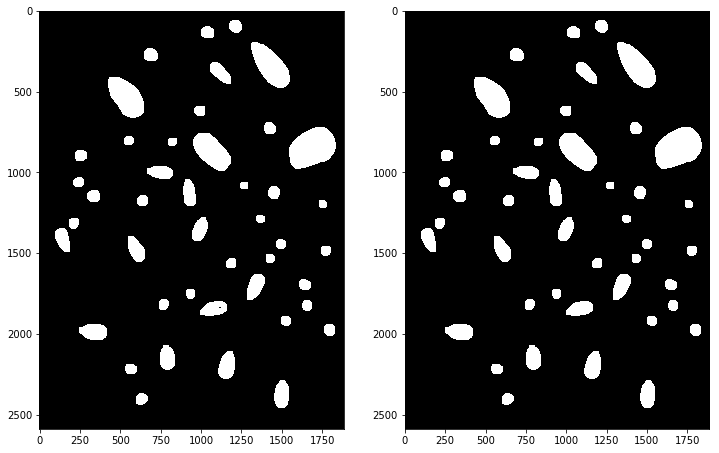

In [11]:
img_preprocessed = morphology.binary_closing(img_opened, np.ones([11,11]))
plot_subplots(img_opened, img_preprocessed)

## Feature extraction

In [12]:
def calc_rectangularity(area, bbox_area):
    return area/bbox_area


def calc_roundness(area, perimeter):
    return (4*np.pi*area)/perimeter**2


def calc_elongation(bbox_width, bbox_length):
    return 1 - bbox_width/bbox_length

### Find objects - connected-components labeling

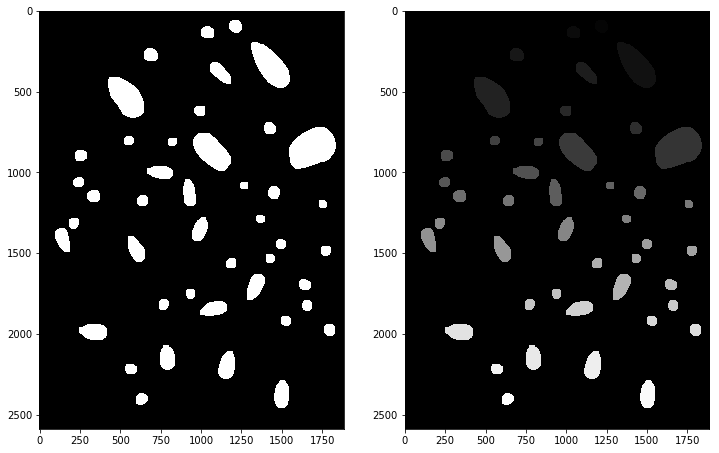

In [13]:
img_labeled = measure.label(img_preprocessed, connectivity=2)
plot_subplots(img_preprocessed, img_labeled)

### Use regionprops to find some of the object properties/features

In [14]:
regionprops = measure.regionprops(img_labeled)

### Get object labels (exclude 0 - background)

In [15]:
labels = np.unique(img_labeled)[1:]
print(labels)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


### Extract features and construct the features vector for each object
Features:

- roundness
- rectangularity
- elongation
- R channel of RGB color
- G channel of RGB color

In [16]:
feature_vectors = []
for label, rp in zip(labels, regionprops):
    # get object of specific label
    obj = img_labeled == label
    # roundness
    roundness = calc_roundness(rp.area, rp.perimeter)
    # rectangularity
    rectangularity = calc_rectangularity(rp.area, rp.bbox_area)
    # elongation
    elongation = calc_elongation(rp.bbox[3] - rp.bbox[2], rp.bbox[1] - rp.bbox[0])
    # R color channel
    red_color = img[:,:,0][obj].mean()
    # G color channel
    green_color = img[:,:,1][obj].mean()
    # construct feature vector
    feature_vector = [roundness, rectangularity, elongation, red_color, green_color]

    # add feature vector to the list containing feature vectors of the other objects
    feature_vectors.append(feature_vector)

## Object classification - K-means clustering

### Convert list of features vectors to numpy array

In [17]:
feature_vectors = np.array(feature_vectors)

### K-means clustering

#### Calculate centorids

In [19]:
# initial_k = np.stack([feature_vectors[10], feature_vectors[12], feature_vectors[14]])
initial_k = 3
centroids, _ = kmeans(feature_vectors, k_or_guess=initial_k, iter=20000, thresh=0.01)
print(centroids)

[[ 7.75385459e-01  6.55755055e-01  5.44380507e-01  1.10718448e+02
   1.03734816e+02]
 [ 9.38238919e-01  8.87258518e-01 -1.16063241e-02  1.24411123e+02
   6.97362628e+01]
 [ 7.66768317e-01  7.65716260e-01 -6.48000504e-02  8.47906293e+01
   7.69931713e+01]]


#### Assign class to each observation

In [20]:
classes, _ = vq(feature_vectors, centroids)
print(classes)

[1 1 0 1 2 0 1 1 0 0 1 1 1 2 1 2 1 1 1 1 1 1 2 1 2 2 1 1 1 1 2 1 1 1 1 2 1
 1 2 2 2 1 2 1]


### Create mask for each class

In [21]:
masks = {}
for c in np.unique(classes):
    mask = np.zeros(img_labeled.shape)
    for label in labels[classes == c]:
        mask += img_labeled == label
    masks = {**masks, c: mask.astype(bool)}

### Mark classified objects

In [22]:
def mark_objects(img, mask, colors):
    img_copy = img.copy()
    img_copy[mask, 0] = colors[0]
    img_copy[mask, 1] = colors[1]
    img_copy[mask, 2] = colors[2]
    plt.figure(figsize=(16,24))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.subplot(1,3,3)
    plt.imshow(img_copy)
    plt.show()

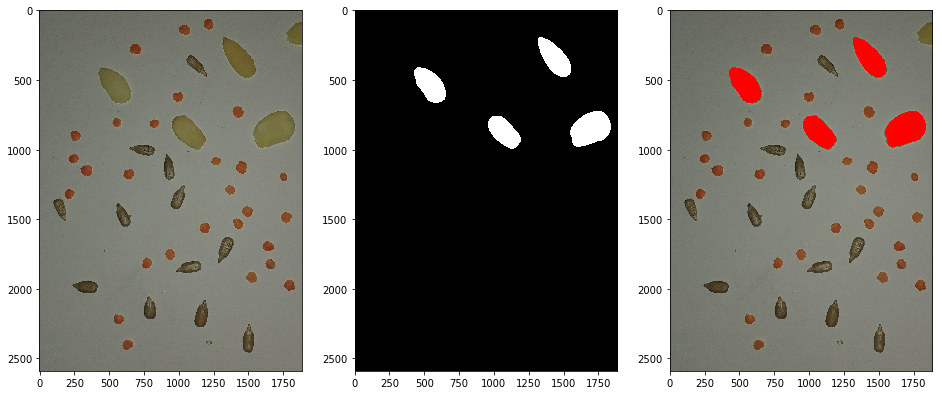

In [23]:
mark_objects(img, masks[0], (255,0,0))

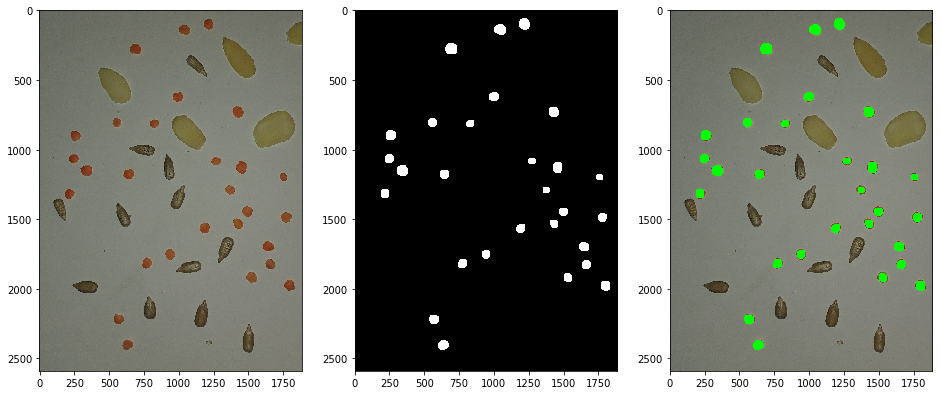

In [24]:
mark_objects(img, masks[1], (0,255,0))

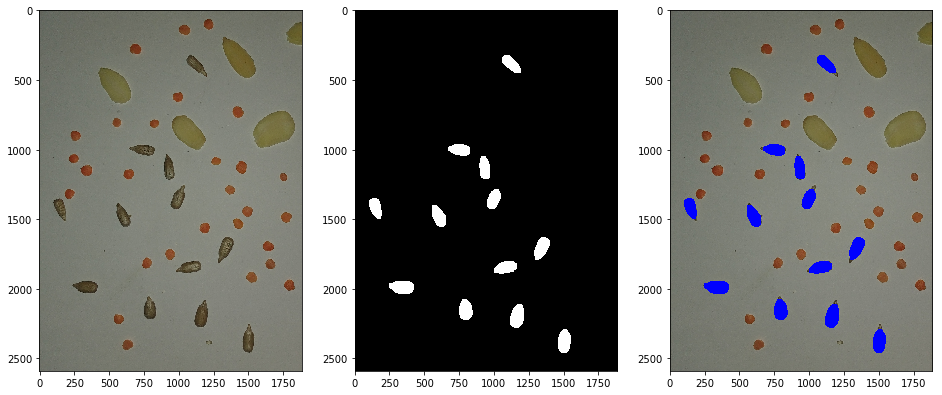

In [25]:
mark_objects(img, masks[2], (0,0,255))